In [1]:
import numpy as np
import random as rd
import tensorflow as tf

from keras.layers import Dense, Embedding, Dropout, LSTM, Input, Flatten
from keras.models import Model
from keras.optimizers import RMSprop

#Import another jupyter notebook
import import_ipynb
from AttentionLayer import *
from Productive_CrossValidation_inclTest import *
from Productive_Data_GetTrainTest import samEval

C:\Users\twitter\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


importing Jupyter notebook from AttentionLayer.ipynb
importing Jupyter notebook from Productive_CrossValidation_inclTest.ipynb
importing Jupyter notebook from Productive_TimeHistory.ipynb
importing Jupyter notebook from Productive_Data_GetTrainTest.ipynb


In [2]:
#for reproducability of the results
seed = 7
np.random.seed(seed)
tf.set_random_seed(seed)
rd.seed(seed)

In [3]:
path = 'data/'
outputpath ='outputs/00_basic_samEval2018/'

In [4]:
#Load necessary data
train_data, train_labels, test_data, test_labels, word_index, MAX_SEQUENCE_LENGTH = samEval()

In [5]:
#Load pretrained embeddings
import gensim
from gensim.models import KeyedVectors

#Pretrained Google News Embeddings, Dimension 300
GOOGLEEMB = path + 'GoogleNews-vectors-negative300.bin'

embedding= KeyedVectors.load_word2vec_format(GOOGLEEMB, binary=True)

word_vectors = embedding.wv

C:\Users\twitter\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


In [6]:
#Create embedding-matrix, serves the Keras Embedding Layer as weigths
EMBEDDING_DIM=300

embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector   
    except:
        # words not found in embeddings will be zero
        pass

## Modelarchitecture

In [7]:
#Hyperparameters
NUM_EPOCHS = 30
BATCH_SIZE = 64
softmax = True
optimizer = RMSprop(lr=0.001, rho = 0.9, epsilon = 0.0000001)
lossfunction ='binary_crossentropy'

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
#Empedding: inputdim = length of vocabulary in input (text) data, outputdim = EMBEDDING_DIM
wv_layer = Embedding(len(word_index)+1,
                     EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=True)

#Input Layer
comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

#Embedding Layer
embedded_sequences = wv_layer(comment_input)

#LSTM Layer
x = LSTM(400, return_sequences=True, activation='tanh', recurrent_activation='sigmoid')(embedded_sequences)

#Attention Layer
x = Attention()(x)

#Dropout Layer
x = Dropout(0.2)(x)

#Dense Layer
x = Dense(400, activation="relu")(x)

#Output (Dense) Layer
preds = Dense(2, activation='softmax')(x)

#Build the model
model = Model(inputs=[comment_input], outputs=preds)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Train and evaluate the model

Instructions for updating:
Use tf.cast instead.


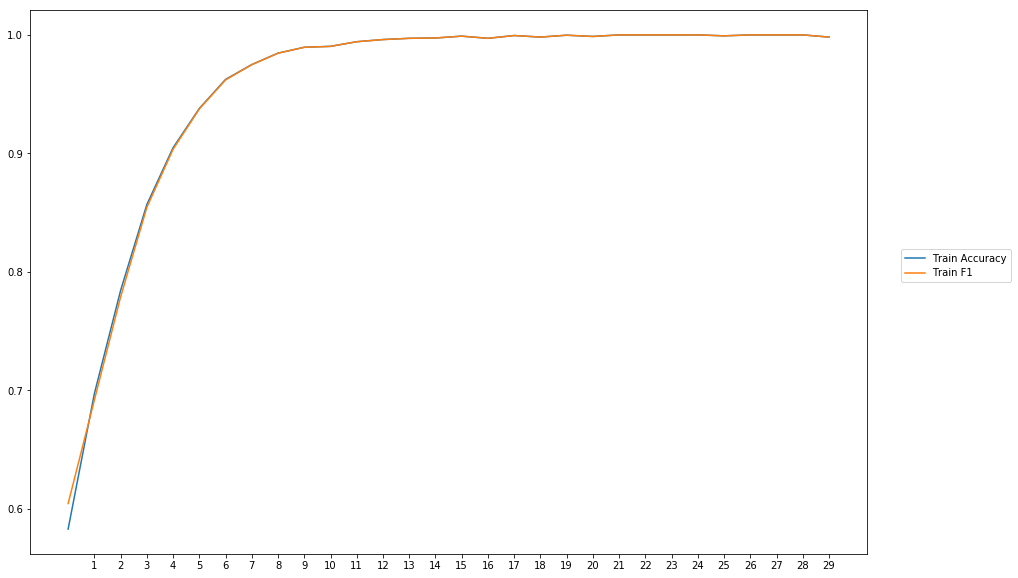


-----Test Scores----
Loss: 3.892851839260179
Accuracy: 65.3061224489796
Precision: 54.67625897969395
Recall: 73.31189708253638
F1: 62.63735772615816


In [9]:
train_evaluate_final_model(model, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_labels, test_data, test_labels, softmax, outputpath, 'BasicSamEval')